<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reading-a-netcdf-file" data-toc-modified-id="Reading-a-netcdf-file-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reading a netcdf file</a></span></li><li><span><a href="#By-default-netCDF4-converts-netcdf-variables-to-masked-arrays" data-toc-modified-id="By-default-netCDF4-converts-netcdf-variables-to-masked-arrays-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>By default netCDF4 converts netcdf variables to masked arrays</a></span><ul class="toc-item"><li><span><a href="#How-much-liquid-water-is-in-the-domain?" data-toc-modified-id="How-much-liquid-water-is-in-the-domain?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>How much liquid water is in the domain?</a></span></li><li><span><a href="#As-expected,-vapor-transport-dominates-the-energy-flux-in-the-warm-marine-boundary-layer" data-toc-modified-id="As-expected,-vapor-transport-dominates-the-energy-flux-in-the-warm-marine-boundary-layer-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>As expected, vapor transport dominates the energy flux in the warm marine boundary layer</a></span></li></ul></li><li><span><a href="#Now-look-at-the-individual-budget-terms" data-toc-modified-id="Now-look-at-the-individual-budget-terms-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Now look at the individual budget terms</a></span></li><li><span><a href="#Save-all-this-in-a-dictionary" data-toc-modified-id="Save-all-this-in-a-dictionary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save all this in a dictionary</a></span></li><li><span><a href="#check-some-values" data-toc-modified-id="check-some-values-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>check some values</a></span></li><li><span><a href="#Do-a-checkpoint-save-for-all-the-variables" data-toc-modified-id="Do-a-checkpoint-save-for-all-the-variables-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Do a checkpoint save for all the variables</a></span></li></ul></div>

# Including water vapor in the tropical analysis

1.  What do the fluxes of sensible and latent heat look like for the tropical case?

1.  Drill down into the data using

    a.  Two dimensional histograms
    
    b.  images with normalized color pallettes

## Reading a netcdf file

1.  Fetch the netcdf file tropical.nc from my webserver (50 Mbytes)

In [1]:
import context
import urllib.request
import numpy as np
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from a500.utils.ncdump import ncdump
import a500
from a500.thermo import calc_theta
import copy

******************************
context imported. Front of path:
/Users/phil/repos/a500_notebooks
/Users/phil/repos/a500_notebooks/notebooks
******************************

through /Users/phil/repos/a500_notebooks/notebooks/context.py -- pha
through /Users/phil/repos/a500_notebooks/a500/__init__.py pha II


In [2]:
from a500.utils.data_read import download
the_root = "http://clouds.eos.ubc.ca/~phil/docs/atsc500"
the_file =  "tropical_subset.nc"
out=download(the_file,root=the_root,dest_folder=a500.data_dir)
g2kg=1.e-3
kg2g=1.e3

trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/tropical_subset.nc
writing to: /Users/phil/repos/a500_notebooks/data/tropical_subset.nc

tropical_subset.nc already exists
and is 52116281 bytes
will not overwrite



In [3]:
def calc_thetav(theta, wv, wl):
    """
    Thetav using stull 1.5.1a
    
    Parameters
    ----------
    
    theta: float
       potential temperature(K)

    wv: float
       vapor mixing ratio (kg/kg)
       
    wl: float
       liquid mixing ratio (kg/kg)
       
    Returns
    -------
    
    theta_v: float
      virtual potential temperature
    """
    theta_v = theta*(1 + 0.61*wv - wl)
    return theta_v

In [4]:
def xy_avg(var):
    """
    assuming var is 3d with axis (z,y,x)
    take the avg over x followed by the axg over y
    """
    return array3d.mean(axis=2).mean(axis=1)

def do_reynolds(array3d):
    """
        do a spatial-mean reynolds average of a 3d field array3d
        needs dimensions arranged as (z,y,x)
        returns avg(z),perturb(z,y,x)
    """
    avg=array3d.mean(axis=2).mean(axis=1)
    perturb=array3d.T - avg
    perturb=perturb.T
    return avg,perturb

2\.  Identify the file structure using ncdump

In [5]:
with Dataset(a500.data_dir / 'tropical_subset.nc') as ncin:
    ncdump(ncin)

NetCDF Global Attributes:
NetCDF dimension information:
	Name: x
		size: 100
		type: dtype('float32')
		units: 'm'
	Name: y
		size: 110
		type: dtype('float32')
		units: 'm'
	Name: z
		size: 112
		type: dtype('float32')
		units: 'm'
		long_name: 'height'
	Name: time
		size: 1
		type: dtype('float32')
		units: 'd'
		long_name: 'time'
NetCDF variable information for group root:
	Name: p
		dimensions: ('z',)
		size: 112
		type: dtype('float32')
		units: 'mb'
		long_name: 'pressure'
	Name: U
		dimensions: ('time', 'z', 'y', 'x')
		size: 1232000
		type: dtype('float32')
		long_name: 'X Wind Component'
		units: 'm/s'
	Name: V
		dimensions: ('time', 'z', 'y', 'x')
		size: 1232000
		type: dtype('float32')
		long_name: 'Y Wind Component'
		units: 'm/s'
	Name: W
		dimensions: ('time', 'z', 'y', 'x')
		size: 1232000
		type: dtype('float32')
		long_name: 'Z Wind Component'
		units: 'm/s'
	Name: PP
		dimensions: ('time', 'z', 'y', 'x')
		size: 1232000
		type: dtype('float32')
		long_name: 'Pressure

3\.  Read a variable using the netCDF4 module:  http://unidata.github.io/netcdf4-python/

In [6]:
with Dataset(a500.data_dir / 'tropical_subset.nc','r') as nc_in:
    print(list(nc_in.variables.keys()))
    the_height=nc_in.variables['z'][...]
    hit = the_height < 2000.
    zvals = the_height[hit]
    the_temp=nc_in.variables['TABS'][0,hit,:,:]  
    #
    # remove the time dimension since we only have one timestep
    #   
    print('temp shape',the_temp.shape)
    xvals=nc_in.variables['x'][...]
    yvals=nc_in.variables['y'][...]
    print('height shape',zvals.shape)
    the_press=nc_in.variables['p'][hit]
    the_press=the_press*100.  #convert to Pa
    wvel=nc_in.variables['W'][0,hit,:,:]  #m/s
    uvel=nc_in.variables['U'][0,hit,:,:]  #m/s
    vvel=nc_in.variables['V'][0,hit,:,:]  #m/s
    qv=nc_in.variables['QV'][0,hit,:,:]*g2kg  #vapor kg/kg
    ql=nc_in.variables['QN'][0,hit,:,:]*g2kg  #liquid  kg/kg
    pp = nc_in.variables['PP'][0,hit,:,:]  #Pressure perturbation (Pa)
    theta = (calc_theta(the_temp.T,the_press)).T
    thetav = calc_thetav(theta,qv,ql)

['x', 'y', 'z', 'time', 'p', 'U', 'V', 'W', 'PP', 'TABS', 'QV', 'QN', 'QP']
temp shape (39, 110, 100)
height shape (39,)


## By default netCDF4 converts netcdf variables to masked arrays

In [7]:
type(ql), type(qv), type(wvel)

(numpy.ma.core.MaskedArray,
 numpy.ma.core.MaskedArray,
 numpy.ma.core.MaskedArray)

See [the masked array docs](https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html)

### How much liquid water is in the domain?

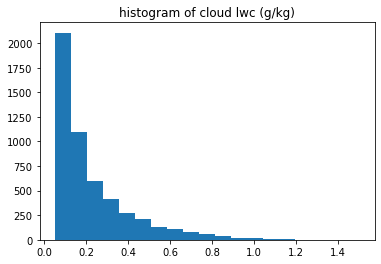

In [8]:
bins=np.linspace(0.05,1.5,20)
out=plt.hist(ql.compressed()*kg2g,bins=bins)
plt.title('histogram of cloud lwc (g/kg)');

# Calculate the temperature and vapor fluxes

In [20]:
Rd=287  #J/kg/K
g2kg = 1.e-3
cpd=1004.
lv = 2.5e6
meter2km = 1.e-3
qv_avg,qv_perturb=do_reynolds(qv)
temp_avg,temp_perturb=do_reynolds(the_temp)
rho_avg=the_press/(Rd*temp_avg)
w_avg,w_perturb = do_reynolds(wvel)
T_flux=((w_perturb*temp_perturb).T*rho_avg).T*cpd  #W/m^2
qv_flux=((w_perturb*qv_perturb).T*rho_avg).T*lv #W/m^2
T_flux_1d=(T_flux).mean(axis=2).mean(axis=1)
qv_flux_1d=(qv_flux).mean(axis=2).mean(axis=1)

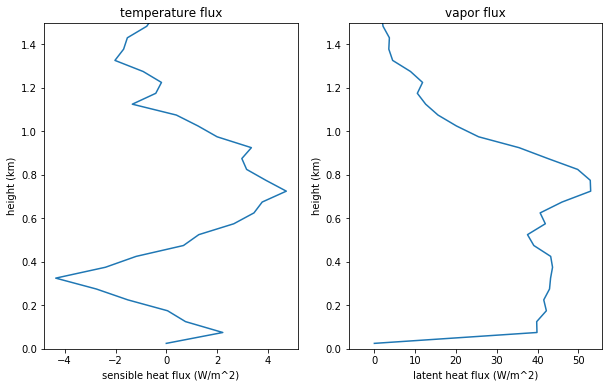

In [21]:
fig,ax=plt.subplots(1,2,figsize=(10,6))
ax[0].plot(T_flux_1d,zvals*meter2km)  
ax[0].set(xlabel='sensible heat flux (W/m^2)',ylabel='height (km)',title='temperature flux')
ax[1].plot(qv_flux_1d,zvals*meter2km)  
out=ax[1].set(xlabel='latent heat flux (W/m^2)',ylabel='height (km)',title='vapor flux')
out=[the_ax.set(ylim=(0,1.5)) for the_ax in ax]

### As expected, vapor transport dominates the energy flux in the warm marine boundary layer

## Now look at the individual budget terms

In [11]:
theta = calc_theta(the_temp.T,the_press)
theta = np.array(theta.T)
keys=['u','v','w','pp','theta','qv','thetav']
values = [uvel,vvel,wvel,pp,theta,qv,thetav]
var_dict=dict(zip(keys,values))

In [12]:
def save_reynolds(key,var):
    """
    given a variable name (key), and the variable
    make two new keys "key_avg" and "key_pert"
    and return the reynolds average and perturbation
    as a dictionary with those keys
    
    Parameters
    ----------
    
    key: string
       name of variable
       
    var: ndarray or masked array
       data array
    """
    new_keys=[f"{key}_avg",f"{key}_pert"]
    avg, perturb = do_reynolds(var)
    return dict(zip(new_keys,(avg,perturb)))

## Save all this in a dictionary

In [13]:
keep_dict = copy.copy(var_dict)
for key, value in var_dict.items():
    #
    # pressure perturbation already done
    #
    if key == 'pp':
        continue
    new_dict = save_reynolds(key, value)
    keep_dict.update(new_dict)
print(keep_dict.keys())

dict_keys(['u', 'v', 'w', 'pp', 'theta', 'qv', 'thetav', 'u_avg', 'u_pert', 'v_avg', 'v_pert', 'w_avg', 'w_pert', 'theta_avg', 'theta_pert', 'qv_avg', 'qv_pert', 'thetav_avg', 'thetav_pert'])


## check some values  

loop through the dictionary and make some histograms

In [14]:
def hist_prep(var):
    """
    compress and unflatten arrays for histogramming
    """
    try:
        #
        # masked array
        #
        var=var.compressed().flat
    except AttributeError:
        #
        # regular ndarray
        #
        var = var.flat
    return var
    


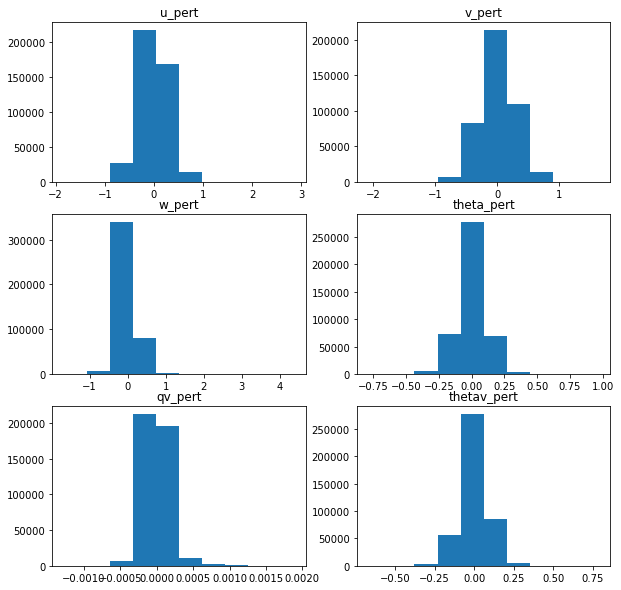

In [15]:
fig, axvec = plt.subplots(3,2,figsize=(10,10))
for count,key in enumerate(['u_pert', 'v_pert', 'w_pert', 'theta_pert','qv_pert','thetav_pert']):
    var=hist_prep(keep_dict[key])
    axvec.flat[count].hist(var)
    axvec.flat[count].set_title(key)

## Do a checkpoint save for all the variables

In [16]:
the_file = a500.data_dir / 'tropical_vapor.npz'
np.savez_compressed(the_file,**keep_dict)

In [17]:
a=np.load(the_file)